In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from collections import Counter

In [2]:
def load_file(f):
    df = pd.read_csv(f)
    return df

In [3]:
def load_data(sym="EUR", to_sym="USD", interval="5min", dtype=2, intraday=False, outputsize="full"):
    key = "ENTER_YOUR_KEY"
    if dtype == 1: # Download stock
        print("STOCKS")
        if intraday:
            url = "https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&interval={}&symbol={}&apikey={}&datatype=csv&outputsize={}".format(interval, sym, key, outputsize)
        else:
            url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&apikey={}&datatype=csv&outputsize={}".format(sym, key, outputsize)
    elif dtype == 2: # Download forex
        print("FX")
        if intraday:
            url = "https://www.alphavantage.co/query?function=FX_INTRADAY&interval={}&from_symbol={}&to_symbol={}&apikey={}&datatype=csv&outputsize={}".format(interval, sym, to_sym, key, outputsize)
        else:
            url = "https://www.alphavantage.co/query?function=FX_DAILY&from_symbol={}&to_symbol={}&apikey={}&datatype=csv&outputsize={}".format(sym, to_sym, key, outputsize)
    elif dtype == 3: # Download Crypto
        print("CRYPTO")
        url = "https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={}&market={}&apikey={}&datatype=csv&outputsize={}".format(sym, to_sym, key, outputsize)
    print("Downloading", url)
    print("---")
    df = pd.read_csv(url)

    # rename columns
    if dtype == 3:
        df.rename(columns={'timestamp': 'Date', 'open (USD)': 'Open', 'high (USD)': 'High', 'low (USD)': 'Low', 'close (USD)': 'Close', 'volume': 'Volume'}, inplace=True)
    else:
        df.rename(columns={'timestamp': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
    df.sort_values(by="Date", ascending=True, inplace=True)
    print("Data loaded:", len(df), "rows")
    return df.reset_index(drop=True)

In [25]:
def plot_candles(sym, df, db, lines=100, wicks=True, shade=True, hline=True):
    """
    sym: symbol
    df: daily data
    db: random out-of-sample data
    lines: plot last n lines
    """
    # Bar heights
    df['Bar'] = df['High'] - df['Low']
    # Body heights
    df['Body'] = abs(df['Close'] - df['Open'])
    # Up or Down bar?
    df['Up'] = df['Close'] > df['Open']
    # Green if up else Red
    g1 = "#27AE60"
    g2 = "#7DCEA0"
    r1 = "#C0392B"
    r2 = "#D98880"
    df['Color'] = np.where(df['Up'], g1, r1)
    # do the same for daily data
    db['Bar'] = db['High'] - db['Low']
    db['Body'] = abs(db['Close'] - db['Open'])
    db['Up'] = db['Close'] > db['Open']
    db['Color'] = np.where(db['Up'], g2 if shade else g1, r2 if shade else r1)
    if lines > 0:
        db1 = df[-lines:].reset_index(drop=True).reset_index()
    else:
        db1 = df.reset_index(drop=True).reset_index()
    idx = list(np.array(np.arange(len(db1), len(db1) + len(db))))
    db["index"] = idx
    db = db.reset_index(drop=True).reset_index()
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    ax.yaxis.tick_right()
    if hline:
        ax.axvline(idx[0], ls="-.", color="#000000", linewidth=0.5)
    ax.text(0.01, 0.95, "Historical Data", transform=plt.gca().transAxes, size=20, horizontalalignment="left")
    ax.text(0.99, 0.95, "OOS Data", transform=plt.gca().transAxes, size=20, horizontalalignment="right")
    if wicks:
        ax.bar(db1['index'], bottom=db1['Low'], height=db1['Bar'], color="#000000", width=0.2)
    ax.bar(db1['index'], bottom=np.where(db1['Up'], db1['Open'], db1['Close']), height=db1['Body'], color=db1['Color'], width=0.9)
    if wicks:
        ax.bar(db['index'], bottom=db['Low'], height=db['Bar'], color="#566573", width=0.2)
    ax.bar(db['index'], bottom=np.where(db['Up'], db['Open'], db['Close']), height=db['Body'], color=db['Color'], width=0.9)
    plt.title(sym + " CHART")
    plt.show()

In [123]:
def out_of_sample_ohlc(df, bars=30, level=1, seed=None, shuffle=True, use_dist=True):
    """
    df: Historical OHLC
    days: How many days to create? Out of sample size
    level: strength of the distribution
    seed: if seed >= 0, we will get random data each time
    """
    np.random.seed(seed)
    # set returns between bars
    df["Returns"] = df["Close"] / df["Open"]
    # set gaps between bars
    df["Gaps"] = df["Open"] / df["Close"].shift(1)
    # set High wicks
    df["Up"] = df["Close"] > df["Open"]
    df["HW"] = df["High"] / np.where(df["Up"], df["Close"], df["Open"])
    df["LW"] = df["Low"] / np.where(df["Up"], df["Open"], df["Close"])
    df = df.dropna()
    # let's create normal distribution data from Returns, Gaps, High wicks and Low wicks
    if use_dist:
        returns = np.random.normal(df["Returns"].mean(), df["Returns"].std(), len(df))
        gaps = np.random.normal(df["Gaps"].mean(), df["Gaps"].std(), len(df))
        hws = np.random.normal(df["HW"].mean(), df["HW"].std(), len(df))
        lws = np.random.normal(df["LW"].mean(), df["LW"].std(), len(df))
    else:
        # here we are using the same probability of occurrence
        returns = df["Returns"].values
        gaps = df["Gaps"].values
        hws = df["HW"].values
        lws = df["LW"].values
    if shuffle:
        np.random.shuffle(returns)
        np.random.shuffle(gaps)
        np.random.shuffle(hws)
        np.random.shuffle(lws)
    ohlc = []
    # get the last day's closing price
    c = df["Close"].iloc[-1]
    for _ in range(bars):
        gap = returns[np.random.randint(len(gaps))]
        #gap = np.random.choice(gaps, 1)[0]
        o = c * gap
        c = o * returns[np.random.randint(len(returns))]
        h = np.max([o, c]) * hws[np.random.randint(len(hws))]
        l = np.min([o, c]) * lws[np.random.randint(len(lws))]
        # in case you would like to use np.random.choice()
        #c = o * np.random.choice(returns, 1)[0]
        #h = np.max([o, c]) * np.random.choice(hws, 1)[0]
        #l = np.min([o, c]) * np.random.choice(lws, 1)[0]
        ohlc.append([o, h, l, c])
    return ohlc

In [45]:
# Settings
sym = "SPY"
intraday = False # False = Daily
to_sym = "USD" # Forex & Crypto only
period = "60min" #intraday only
interval = "15min" # intraday only - 1min, 5min, 15min, 30min, 60min
dtype = 1 # 1: stock 2: fx 3: crypto
df = load_data(sym, to_sym, interval, dtype, intraday=False)

STOCKS
---
Data loaded: 5032 rows


In [142]:
# how many samples do we need?
bars = 50
digit = 2 # 2 for stocks, 5 for FX, 3 for XXXJPY, 8 for Crypto
seed = 50 # Default: None (generate random each time)
shuffle = False
use_dist = False
ohlc = out_of_sample_ohlc(df, bars=bars, level=1, seed=seed, shuffle=shuffle, use_dist=use_dist)
db = pd.DataFrame(columns=["Open", "High", "Low", "Close"], data=np.array(np.round(ohlc, digit)))
db["Returns"] = db["Close"] / db["Open"]
db.tail(10)

,Open,High,Low,Close,Returns
40,282.77,285.79,278.82,279.03,0.986774
41,274.08,274.93,272.89,273.34,0.997300
42,272.90,273.66,267.99,268.80,0.984976
43,270.49,274.18,269.60,272.81,1.008577
44,268.34,269.47,267.32,268.62,1.001043
45,270.08,270.52,269.84,270.11,1.000111
46,269.69,269.96,266.75,268.69,0.996292
47,268.12,268.19,267.27,267.95,0.999366
48,265.46,265.66,265.04,265.48,1.000075
49,271.95,274.30,270.91,271.12,0.996948


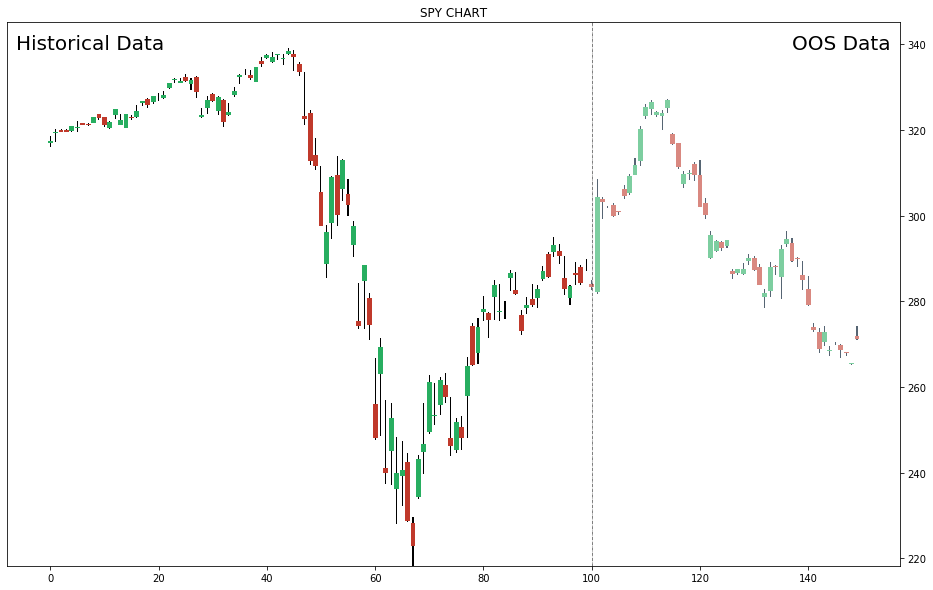

In [143]:
plot_candles(sym, df, db, lines=100, wicks=True, shade=True, hline=True)

[]

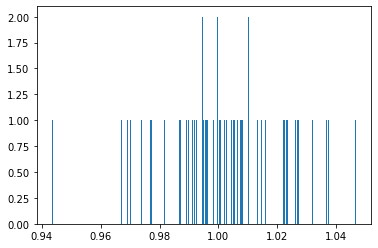

In [144]:
plt.hist(df["Returns"][-bars:], bins=300)
plt.plot()

[]

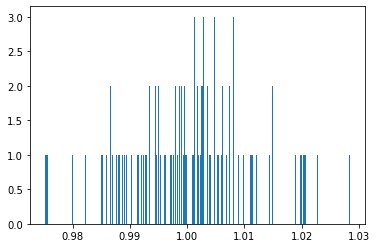

In [131]:
plt.hist(db["Returns"], bins=300)
plt.plot()